In [12]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Math Concepts for Developers
## Exercise: High-school maths
### Problem 9: Perlin Noise
### Solution by: Lyubomir Tankishev

In this notebook I will show my solution for generating 2D Perlin Noise.

#### Contents
1. [What is Perlin Noise?](#what_is)
2. [How does it work?](#how_does_it_work)
3. [Solution](#my_solution)
    1. [Defining the grid](#gen_the_grids)
    2. [Generating the gradient vectors](#gen_gradient_vectors)
    3. [Generating the distance matrix for the distance vectors](#gen_distance_vectors)
    4. [Calculation of the dot products and gradient values](#calculate_gradient)
4. [Putting it all together](#perlin_noise)
5. [Playing around with the code](#lets_play)
6. Next steps

<a id='what_is'></a>
#### 1. What is Perlin Noise

If you are interested in the detailed definition, you can find a lot of detailed information on the internet. That said, in simple terms, Perlin Noise is an algorithm for generation of pseudo random noise with a more organic look & feel to it. This algorithm was created by Ken Perlin in the 1980s to solve the challenge of generating textures with computer algorithm that have a natural look to them. Such procedural generation of textures was needed for the increasing use of computer generated images in the movie industry. Later it was heavily adopted by the computer games as well. 

To understand better the context lets first create a 2D fully random image.

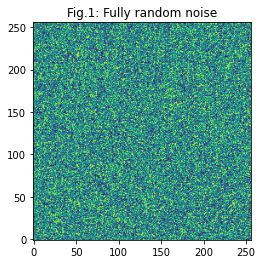

In [13]:
def fully_random_generation(size):
    arr = np.random.rand(size ** 2)
    arr = arr.reshape([size, size])
    plt.imshow(arr)
    plt.gca().invert_yaxis()
    plt.title("Fig.1: Fully random noise")
    plt.show()
    
fully_random_generation(256)

Now, lets compare the image above with the next one which is generated using the 2D Perlin Noise algorithm that is described in this book. One can easily notice that although there is randomness in the image it is much more natural looking.

<p style="text-align: left;"><b>Fig.2:</b> Perlin Noise</p>
<img src="perlin_noise.png" width="256" height="256" align="left"/>

In [3]:
def rotate_vectors(M, degrees=30):
    size = M.shape[0]
    theta = np.deg2rad(degrees)
    T_M = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
#     M = M.reshape(size**2,2).T
    M = np.dot(T_M, M)
#     M = M.T.reshape(size, size, 2)
    return M

In [4]:
def generate_gradient_vectors(number_of_unique_vectors: int, number_of_vectors: int) -> np.ndarray:

    v = np.linspace(0, 2 * np.pi, number_of_unique_vectors + 1)
    vy = np.round(np.sin(v), 5)
    vx = np.round(np.cos(v), 5)
    vectors = tuple(zip(vx, vy))
    
    vector_indexes = list(range(number_of_unique_vectors))
    random_indexes = np.random.choice(vector_indexes, size=number_of_vectors)
    
    retval = np.zeros((2, number_of_vectors))
    retval[0] = np.array([vectors[idx][0] for idx in random_indexes])
    retval[1] = np.array([vectors[idx][1] for idx in random_indexes])
    
    return retval

def corner_matrix(matrix, grid_size, v_num, corner):
    if corner not in ('tr','tl','br','bl'):
        return
    retval = np.zeros((2, grid_size, grid_size))
    el_num = grid_size // (v_num - 1)
    
    for i in range(2):
        m = matrix[i,:]

        m = np.reshape(m, (v_num, v_num))
        m = np.flip(m, 0)

        if corner == 'tl':
            m = m[:-1,:-1]
        elif corner == 'tr':
            m = m[:-1,1:]
        elif corner == 'bl':
            m = m[1:,:-1]
        elif corner == 'br':
            m = m[1:,1:]
    
        m = np.reshape(m.repeat(el_num), ((v_num - 1),grid_size)).repeat(el_num, axis=0)

        retval[i] = m
    return retval

def gen_distance_vectors(size, elements):
    d = np.arange(size)
    r = np.tile(d, size).reshape((size, size))
    D = np.zeros((2, size, size))
    if elements == 1:
        return D
    D[0] = (D[0,:,:] + r % elements) / (elements - 1)
    D[1] = D[0].T
    D = np.flip(D,1)
    return D

def fade_noise(x):
    retval = np.zeros((x.shape))
    retval += x**5 * 6 - x**4 * 15 + x**3 * 10 
    return retval

In [5]:
def generate_perlin(grid_size=256, subgrids=2, unique_vectors_to_select_from=8, vectors_matrix=None):

    # Generate gradient vectors matrixes
    v_num = subgrids + 1
    el_num = grid_size // subgrids
    grid_vectors_number = v_num ** 2
    if vectors_matrix is None:
        V = generate_gradient_vectors(unique_vectors_to_select_from, v_num**2)
    else:
        V = vectors_matrix

    TL = corner_matrix(V, grid_size, v_num, 'tl')
    TR = corner_matrix(V, grid_size, v_num, 'tr')
    BL = corner_matrix(V, grid_size, v_num, 'bl')
    BR = corner_matrix(V, grid_size, v_num, 'br')

    # Generate distance matrix
    D = gen_distance_vectors(grid_size, el_num)

    # Generate interpolation matrix
    X = fade_noise(D[0])
    Y = fade_noise(D[1])

    # Calculate dot products
    DPBL = D[0]*BL[0] + D[1]*BL[1]
    DPBR = (D[0]-1)*BR[0] + D[1]*BR[1]
    DPTL = D[0]*TL[0] + (D[1]-1)*TL[1]
    DPTR = (D[0]-1)*TR[0] + (D[1]-1)*TR[1]

    L1 = DPBL + (DPBR - DPBL) * X
    L2 = DPTL + (DPTR - DPTL) * X
    G = L1 + (L2 - L1) * Y

    return G

def plot_perlin(**kwargs):
    G = generate_perlin(**kwargs)
    plt.imshow(G)
    plt.gca().invert_yaxis()
    plt.show()

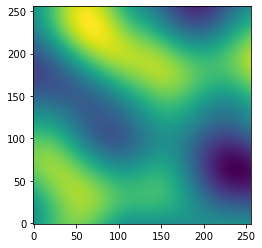

In [6]:
%matplotlib inline
plot_perlin()

<IPython.core.display.Javascript object>


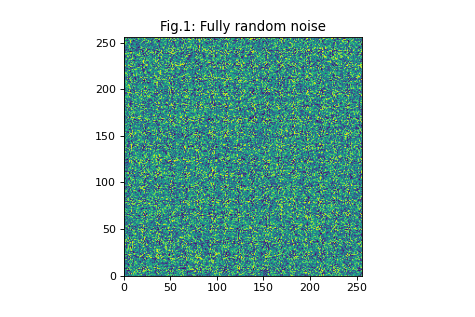

In [7]:
%matplotlib notebook

size = 256
subgrids = 4
unique_vectors_to_select_from = 4
rotation_angle = 5
v_num = subgrids + 1

# Animation set-up
v = generate_gradient_vectors(unique_vectors_to_select_from, v_num**2)
G = generate_perlin(grid_size=size, subgrids=subgrids, vectors_matrix=v)

fig = plt.figure()
ax = plt.axes(xlim=(0, size), ylim=(0, size))
im = plt.imshow(G)

def init():
    global v, G, im
    v  = rotate_vectors(v, rotation_angle)
    G = generate_perlin(grid_size=size, subgrids=subgrids, vectors_matrix=v)   
    im.set_data(G)
    return [im]

# Animation function
def animate(i):
    global v, im, G
    v  = rotate_vectors(v, rotation_angle)
    G = generate_perlin(grid_size=size, subgrids=subgrids, vectors_matrix=v)
    im.set_array(G)
    return [im]

anim = FuncAnimation(fig, animate, init_func=init, frames=600, interval=30, blit=True)
plt.show()